In [61]:
import os
import torch
import matplotlib.pyplot as plt
from torch.functional import F

%matplotlib inline
while not os.getcwd().endswith("nlp-playground"):
    os.chdir("..")
print(os.getcwd())
DATA_DIR = "data"
NAMES_FILE_PATH = os.path.join(DATA_DIR, "names.txt")

/Users/cristian/Personal/Projects/nlp-playground


In [62]:
words = open(NAMES_FILE_PATH, "r").read().splitlines()

In [63]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [64]:
min(len(word) for word in words)

2

In [65]:
max(len(word) for word in words)

15

In [66]:
b = {}
for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


In [67]:
sorted(b.items(), key=lambda x: x[1], reverse=True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [68]:
N = torch.zeros(27, 27, dtype=torch.int32)

In [69]:
chars = ["."] + sorted(list(set("".join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

In [70]:
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        N[idx1, idx2] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

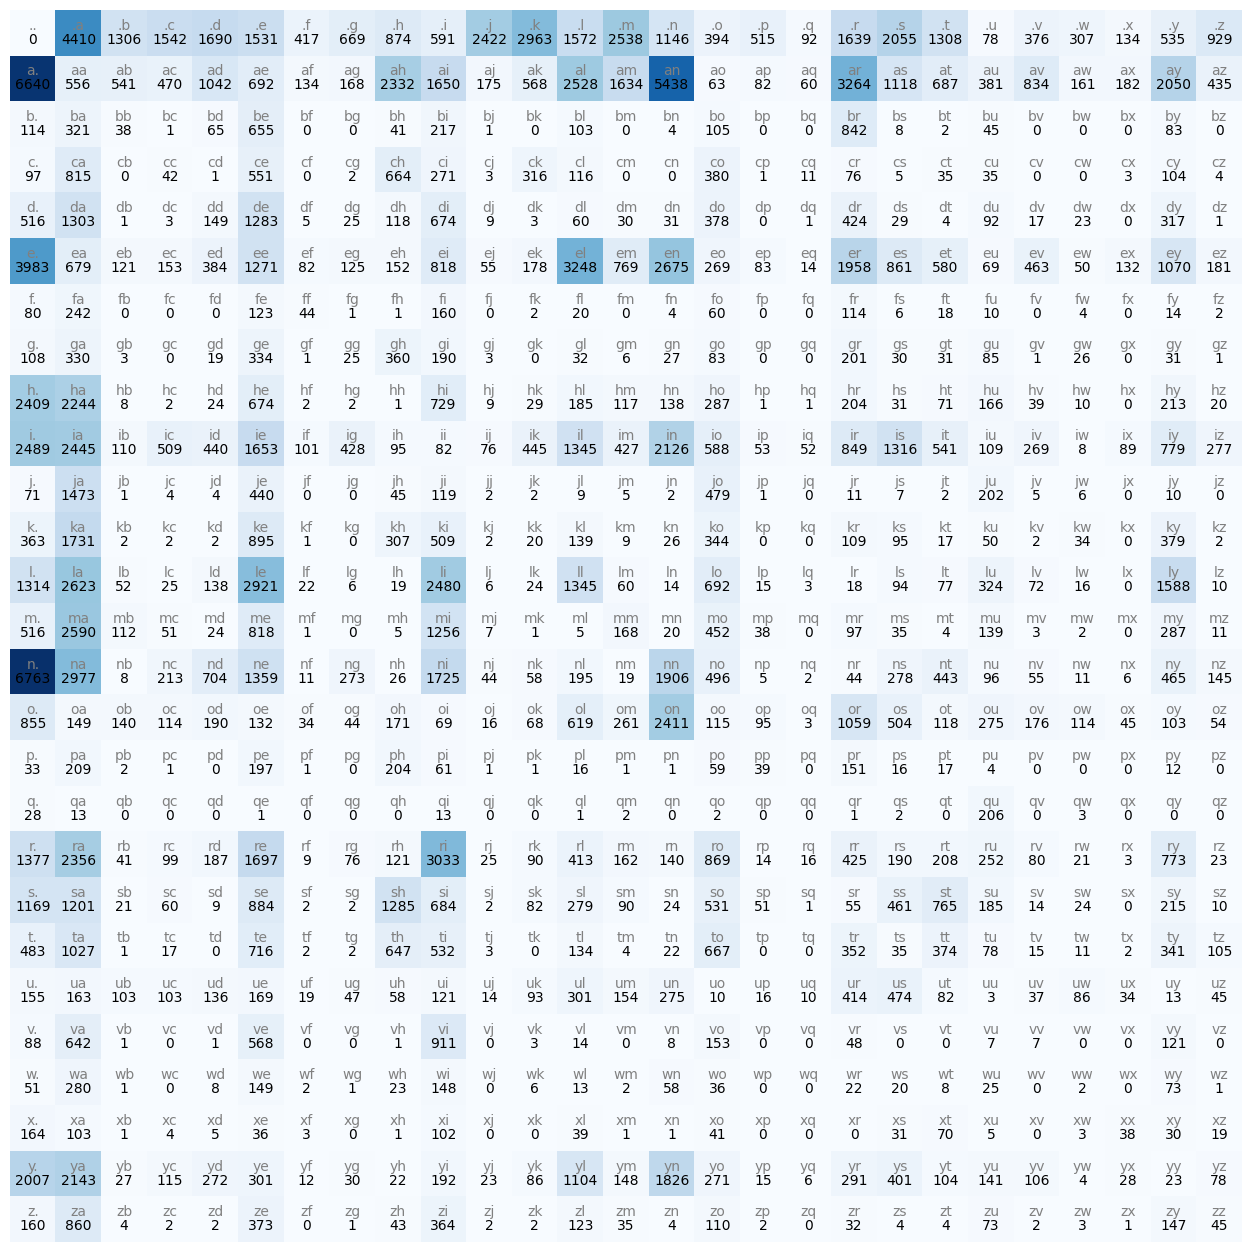

In [71]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="black")
plt.axis("off")


In [72]:
P = (N + 1).float() / N.sum(dim=1, keepdim=True)
print(P[:, 0].sum())
print(P[1].sum())


tensor(3.0347)
tensor(1.0008)


In [73]:
g = torch.Generator().manual_seed(2147483647)

ix = 0
for i in range(6):
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.


In [74]:
log_likelihood = 0
n = 0
for w in ["andrejq"]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        logprob = -torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")

print(f"log likelihood: {log_likelihood / n:.4f}")

.a: 0.1377 1.9827
an: 0.1605 1.8294
nd: 0.0385 3.2579
dr: 0.0773 2.5597
re: 0.1337 2.0122
ej: 0.0027 5.8991
jq: 0.0003 7.9725
q.: 0.1066 2.2385
log likelihood: 3.4690


In [125]:
# create the training set of bigrams (x, y)
xs, ys = [], []
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        xs.append(idx1)
        ys.append(idx2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
print(f"Number of examples: {num}")

Number of examples: 228146


In [129]:
for k in range(300):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    W.grad = None
    loss.backward()
    W.data -= 50 * W.grad
    print(loss.item())

2.4721853733062744
2.4719767570495605
2.4717726707458496
2.4715726375579834
2.471376895904541
2.4711852073669434
2.4709975719451904
2.470813035964966
2.470633029937744
2.47045636177063
2.470283269882202
2.470113515853882
2.46994686126709
2.4697835445404053
2.469623565673828
2.4694664478302
2.4693124294281006
2.46916127204895
2.46901273727417
2.468867063522339
2.468724012374878
2.468583822250366
2.4684455394744873
2.4683103561401367
2.468177556991577
2.4680464267730713
2.4679183959960938
2.46779203414917
2.467668294906616
2.467546224594116
2.4674265384674072
2.467308759689331
2.4671928882598877
2.467078924179077
2.4669671058654785
2.4668571949005127
2.4667487144470215
2.466642141342163
2.4665372371673584
2.4664340019226074
2.4663326740264893
2.4662327766418457
2.4661340713500977
2.4660372734069824
2.465942144393921
2.465847969055176
2.4657552242279053
2.4656641483306885
2.4655747413635254
2.4654862880706787
2.4653990268707275
2.465312957763672
2.465228319168091
2.4651451110839844
2.4650

In [112]:
W.data -= 0.1 * W.grad

In [113]:
loss

tensor(3.7292, grad_fn=<NegBackward0>)

In [85]:
nlls = torch.zeros(5)
for i in range(5):
    # ith bigram
    x = xs[i].item()
    y = ys[i].item()
    print("---------")
    print(f"bigram example {i + 1}: {itos[x]}{itos[y]} (indexes {x}, {y})")
    print(f"input to the neural net {x}")
    print(f"output probabilities from the neural net: {probs[i]}")
    print(f"label (actual next character): {y}")
    p = probs[i, y]
    print(f"probability assigned by the net to the correct character: {p.item()}")
    logp = torch.log(p)
    print(f"log likelihood of the actual next character: {logp.item()}")
    nll = -logp
    print(f"negative log likelihood: {nll.item()}")
    nlls[i] = nll

print("=========")
print(f"average negative log likelihood: {nlls.mean().item()}")

---------
bigram example 1: .e (indexes 0, 5)
input to the neural net 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the correct character: 0.012286250479519367
log likelihood of the actual next character: -4.3992743492126465
negative log likelihood: 4.3992743492126465
---------
bigram example 2: em (indexes 5, 13)
input to the neural net 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to